<a href="https://colab.research.google.com/github/c-daly/Notebooks/blob/main/SVM_NeuralNets_RandomForest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CS 6140 Machine Learning: Assignment - 3 (Total Points: 100)
## Prof. Ahmad Uzair 

# Q1. Implement Support Vector Machines (SVMs) from scratch (35 Points)

## 1. Generate and visualize data: 
Run the following code to generate non-linearly separable data. 

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import random

def gen_data():
    np.random.seed(105)
    Positive = np.concatenate((np.random.randn(10, 2) * 0.4 + [1.5, -0.5],
                             np.random.randn(10, 2) * 0.4 + [-1.5, 0.5]))
    Negative = np.random.randn(20, 2) * 0.3 + [0.0, -0.9]

    return Positive, Negative

## 2. Plot data
Perform data visualization on the above generated data. 


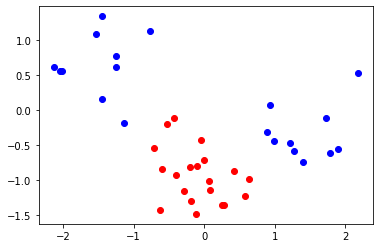

In [23]:
def plot_data(Positive, Negative):
  positive_x = Positive[:,0]
  positive_y = Positive[:,1]
  negative_x = Negative[:,0]
  negative_y = Negative[:,1]

  # two separate plots to conveniently handle
  # class colors
  plt.scatter(positive_x, positive_y, c='b')
  plt.scatter(negative_x, negative_y, c='r')


positive, negative = gen_data()
plot_data(positive, negative)

Expected output for visualization

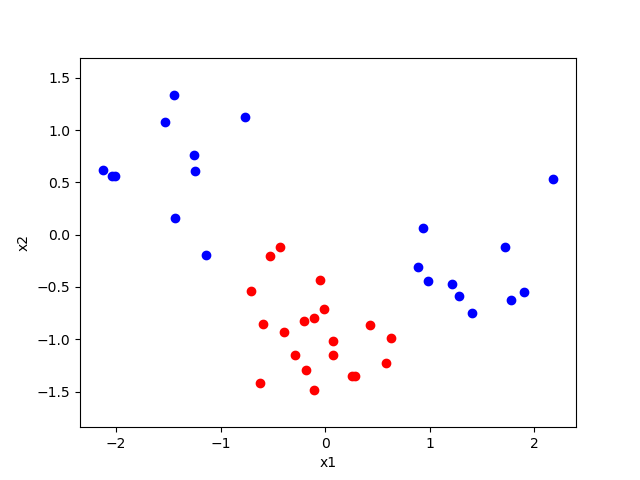

## 3. Fit SVM with linear kernel with slack variable (10+5 Points)
  - Implement **SVM with linear kernel**. Explain why training the linear kernel model without C would fail?  **(10 Points)**
Hint : You can use [minimize()](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html) of scipy.optimize for optimization of the dual function.  
  $max_\lambda q(λ) = \sum_i \lambda_i - \frac{1}{2}\sum_{ij} y_i y_j \lambda_i \lambda_jk(x_i, x_j)$

  You may need to modify the formulation to convert objective from maximization to minimization.
  $min_\lambda q(λ) = \frac{1}{2}\sum_{ij} y_i y_j \lambda_i \lambda_jk(x_i, x_j) - \sum_i \lambda_i$

  The minimize() function returns a dictionary that contains the optimal values of $\lambda$s stored in 'x' key. 
  - **Optimize slack variable**:  Fit linear kernel using C in [0,1,2,3,4,5]. Explain the effect of different choices of C.  **(5 Points)**


In [24]:
def linear_kernel(x, y, **kwargs):
    # insert your code here 
    # return linear kernel output
    return x.dot(y)

In [25]:
from scipy.optimize import minimize, Bounds
C = 0
def fit(X, Y, C, kernel=linear_kernel, **kwargs):
    '''
    X: input_data (Nx2) numpy array
    Y: binary target variable (N,) numpy array
    C: The slack variable
    kernel: kernel function (linear or polynomial)
    kwargs: dictionary of arguments
    '''
    # insert your code here
    # Apply optimization of dual function (Equation 7.10: Bishop)
    # make use of minimize()
    # 
    if C is None:
      C = 0

    def preprocess(input_data, target_data, kernel, **kwargs):
      N = input_data.shape[0]
      preprocessed = np.zeros((N,N))
      for i in range(N):
          for j in range(N):
              preprocessed[i][j] = target_data[i] * target_data[j] * kernel(x=input_data[i], y=input_data[j], **kwargs)
      return preprocessed
    preprocessed = preprocess(X, Y, kernel, **kwargs)

    def compute_helper(alpha):
        N = alpha.shape[0]  
        add_core = 0
        add_alpha = 0
        for i in range(N):
            add_alpha = add_alpha + alpha[i]
            for j in range(N):
                add_core = add_core + alpha[i] * alpha[j] * preprocessed[i][j]
        minimize_objective = 0.5 * add_core - add_alpha
        return minimize_objective
        
    def equality_constraint(alpha):
        return np.dot(alpha,Y)

    constraints = ({'type': 'eq', 'fun': equality_constraint})

    if C == 0:
      upper_limit = None
    else:
      upper_limit = C - 0.00000001
    bounds = [(0, upper_limit)]*X.shape[0]
    #x0 = np.random.rand(X.shape[0])
    x0 = np.zeros(X.shape[0])

    optRes = minimize(compute_helper, x0, constraints=constraints, bounds=bounds)

    a = optRes.x

    a[np.isclose(a, 0)] = 0
    a[np.isclose(a, C)] = C
    
    return a


## 4. Linear Kernel decision boundary visualizaiton (10 Points)
Visualize datapoints and SVM decision boundary and margins with C=5. Color misclassified points appropriately. 
- Implement get_support_vectors() method that return support vectors based on 
- This would require you to implement a predict() method. (Slide 3 or Equation 7.13 : Bishop)




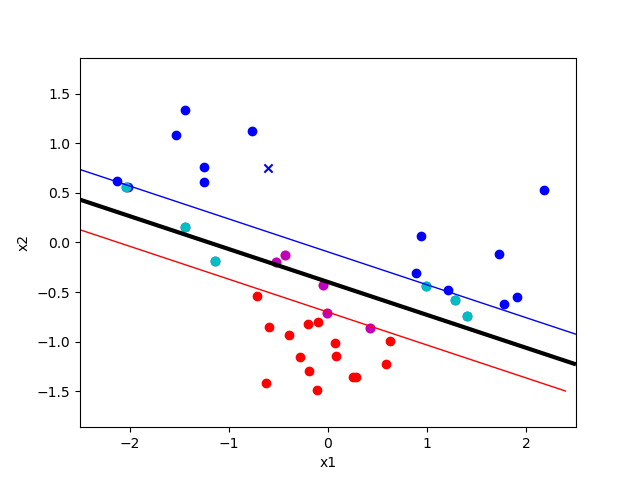

Test runs are displayed below all the code.

In [26]:
def svm_bias(X,Y,lambdas):
  w = np.sum(lambdas*Y*X.T,axis = 1)[:,np.newaxis]
  w0 = np.mean(Y-np.dot(X,w))
  return w0

def get_support_vectors(X, Y, lambdas, threshold=10e-5):
  # insert your code here
  # return support vectors, target variable values of the support vectors, lambdas of support vectoss
  # remeber only lambdas >=0 are to be kept
  #support_idx = np.where((threshold < lambdas))[0]
  #support_idx = np.where((0 < lambdas))[0]
  support_idx = np.where((0 < lambdas))[0]
  support_X = X[support_idx]
  support_Y = Y[support_idx]
  support_lambdas = lambdas[support_idx]
  b = svm_bias(support_X, support_Y, support_lambdas) 
  return support_X, support_Y, support_lambdas, b 


In [27]:
def predict(test_point, s_vecs, s_vecs_Y, s_vecs_lambda, b, kernel, **kwargs):
  '''
  test_point: test datapoint
  s_vecs: Support vectors 
  s_vecs_Y: target values of the Support vectors
  s_vec_lambda: Dual variables corresponding to the support vectors
  kernel, kwargs: kernel function (linear or polynomial)
  '''
  # insert your code here
  # Apply support vectors to predict the class of test_point (Equation 7.13: Bishop)
  alpha_y = s_vecs_lambda * s_vecs_Y
  xTx = kernel(s_vecs, test_point.T)
  prediction = alpha_y.T.dot(xTx) + b
  return prediction


In [28]:
def plot_decision_boundary(Positive, Negative,
                           ip_new,
                           s_vecs, s_vecs_Y, s_vec_lambda,
                           b,
                           kernel,
                           **kwargs):
  '''
  Positive, Negative: Example datapoints from both classes
  test_point: test data point (2, )
  s_vecs: Support vectors
  s_vecs_Y: Target variable values for the support vectors
  s_vec_lambda: Dual variables corresponding to the support vectors
  kernel, kwargs: kernel function (linear or polynomial)
  '''
  # make use of plt.contour() and plt.scatter()
  # plot decision boundary along with margins
  plt.ion()
  positive_x = Positive[:,0]
  positive_y = Positive[:,1]
  negative_x = Negative[:,0]
  negative_y = Negative[:,1]

  test_prediction = predict(ip_new,
                         s_vecs,
                         s_vecs_Y,
                         s_vec_lambda,
                         b,
                         kernel=linear_kernel)
  color = 'b' 
  if test_prediction < 0:
    color = 'r'
  fig = plt.figure()
  ax = fig.add_subplot()
  ax.scatter(positive_x, positive_y, c='b')
  ax.scatter(negative_x, negative_y, c='r')

  ax.scatter(s_vecs.T[0], s_vecs.T[1], color='g', s=100, facecolors='none', edgecolors='g', label='support vectors')
  ax.scatter(ip_new[0], ip_new[1], color=color, marker='x', label='new')
  # plot the decision boundary and margins in the input space
  grid = np.arange(X.min(), X.max(), 0.05)
  xx, yy = np.meshgrid(grid, grid)

  zs = predict(np.array(list(zip(np.ravel(xx), np.ravel(yy)))), s_vecs, s_vecs_Y, s_vec_lambda, b, kernel)
  zz = zs.reshape(xx.shape)
  CS = ax.contour(xx, yy, zz, levels=[-1, 0, 1], )
  fig.show()

The following function will be used to test your solution.

In [29]:
# Test code
def test_linear_kernel(X,y,C):

    lambdas = fit(X,
                Y,
                C,
                kernel=linear_kernel,
                kwargs={})
    # Get the alpha values for the support vectors, as well as their target data.
    s_vecs, s_vecs_Y, s_vecs_lambda, b = get_support_vectors(X,
                                                         Y,
                                                         lambdas)
    print(f"{s_vecs.shape[0]} support vectors found.\\n", s_vecs)
    # test new data point
    ip_new = np.array([-0.6, 0.75])
    prediciton = predict(ip_new,
                         s_vecs,
                         s_vecs_Y,
                         s_vecs_lambda,
                         b,
                         kernel=linear_kernel)

    print(f"New point prediction: {prediciton}")
    plot_decision_boundary(  Positive, Negative,
                             ip_new,
                             s_vecs,
                             s_vecs_Y,
                             s_vecs_lambda,
                             b,
                             kernel=linear_kernel)

Positive, Negative = gen_data()
# plot_data(Positive, Negative)
X = np.concatenate((Positive, Negative))
Y = np.concatenate((np.ones(Positive.shape[0]), -np.ones(Negative.shape[0])))
size = X.shape[0]
shuffle_data = list(range(size))
random.shuffle(shuffle_data)
X = X[shuffle_data, :]
Y = Y[shuffle_data]

40 support vectors found.\n [[ 0.07742877 -1.14931829]
 [-0.10434967 -0.80116922]
 [-0.52528106 -0.19958112]
 [-2.1300322   0.61799457]
 [ 0.88640301 -0.31171598]
 [-0.43042553 -0.1224234 ]
 [ 1.90223209 -0.55125585]
 [ 1.72225459 -0.11974027]
 [ 1.2778755  -0.58188648]
 [ 0.25602264 -1.35327514]
 [ 0.62905985 -0.99111128]
 [-2.03524537  0.56015045]
 [-0.11132172 -1.48342931]
 [-0.59376991 -0.84960436]
 [-0.28625899 -1.15067218]
 [-1.53690053  1.07849279]
 [ 1.77592671 -0.62091129]
 [ 2.18190517  0.52953827]
 [-0.18664454 -1.2922903 ]
 [ 0.28036696 -1.35396003]
 [ 1.40186973 -0.74534088]
 [ 0.58299574 -1.22404863]
 [-1.14212888 -0.19215842]
 [ 0.98524228 -0.44313042]
 [ 0.42448628 -0.86445712]
 [ 1.20929285 -0.47625357]
 [-0.20376774 -0.82076316]
 [-0.76590095  1.12063704]
 [ 0.93775459  0.06812878]
 [ 0.07112504 -1.01239012]
 [-1.247687    0.60864115]
 [-0.39561007 -0.93109048]
 [-0.00892175 -0.71463001]
 [-2.01477484  0.55726986]
 [-1.25314624  0.7644046 ]
 [-1.44075191  0.15927811]


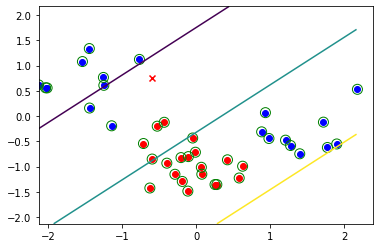

In [30]:
test_linear_kernel(X,Y,0)

17 support vectors found.\n [[-0.10434967 -0.80116922]
 [-0.52528106 -0.19958112]
 [-0.43042553 -0.1224234 ]
 [ 1.2778755  -0.58188648]
 [ 0.62905985 -0.99111128]
 [-2.03524537  0.56015045]
 [ 1.77592671 -0.62091129]
 [ 1.40186973 -0.74534088]
 [-1.14212888 -0.19215842]
 [ 0.98524228 -0.44313042]
 [ 0.42448628 -0.86445712]
 [ 1.20929285 -0.47625357]
 [-0.00892175 -0.71463001]
 [-2.01477484  0.55726986]
 [-1.44075191  0.15927811]
 [-0.04612834 -0.43374017]
 [-0.71154051 -0.54219998]]
New point prediction: 2.5613017089298244


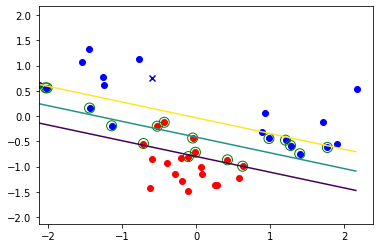

In [31]:
test_linear_kernel(X,Y,1)

12 support vectors found.\n [[-0.52528106 -0.19958112]
 [-0.43042553 -0.1224234 ]
 [ 1.2778755  -0.58188648]
 [-2.03524537  0.56015045]
 [ 1.40186973 -0.74534088]
 [-1.14212888 -0.19215842]
 [ 0.98524228 -0.44313042]
 [ 0.42448628 -0.86445712]
 [-0.00892175 -0.71463001]
 [-1.44075191  0.15927811]
 [-0.04612834 -0.43374017]
 [-0.71154051 -0.54219998]]
New point prediction: 2.8815042670547752


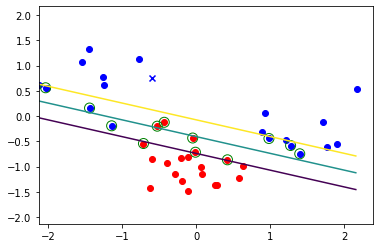

In [32]:
test_linear_kernel(X,Y,2)

12 support vectors found.\n [[-0.52528106 -0.19958112]
 [-0.43042553 -0.1224234 ]
 [ 1.2778755  -0.58188648]
 [-2.03524537  0.56015045]
 [ 1.40186973 -0.74534088]
 [-1.14212888 -0.19215842]
 [ 0.98524228 -0.44313042]
 [ 0.42448628 -0.86445712]
 [-0.00892175 -0.71463001]
 [-1.44075191  0.15927811]
 [-0.04612834 -0.43374017]
 [-0.71154051 -0.54219998]]
New point prediction: 2.886362784041803


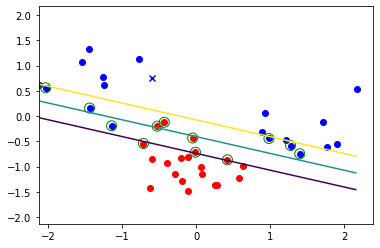

In [33]:
test_linear_kernel(X,Y,3)

11 support vectors found.\n [[-0.52528106 -0.19958112]
 [-0.43042553 -0.1224234 ]
 [ 1.2778755  -0.58188648]
 [-2.03524537  0.56015045]
 [ 1.40186973 -0.74534088]
 [-1.14212888 -0.19215842]
 [ 0.98524228 -0.44313042]
 [ 0.42448628 -0.86445712]
 [-0.00892175 -0.71463001]
 [-1.44075191  0.15927811]
 [-0.04612834 -0.43374017]]
New point prediction: 3.127074480736293


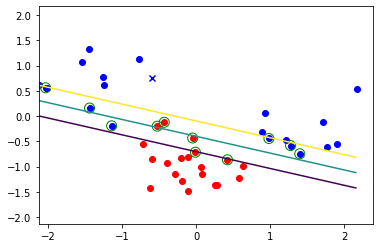

In [34]:
test_linear_kernel(X,Y,4)

11 support vectors found.\n [[-0.52528106 -0.19958112]
 [-0.43042553 -0.1224234 ]
 [ 1.2778755  -0.58188648]
 [-2.03524537  0.56015045]
 [ 1.40186973 -0.74534088]
 [-1.14212888 -0.19215842]
 [ 0.98524228 -0.44313042]
 [ 0.42448628 -0.86445712]
 [-0.00892175 -0.71463001]
 [-1.44075191  0.15927811]
 [-0.04612834 -0.43374017]]
New point prediction: 3.127299689618801


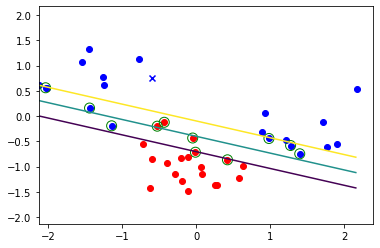

In [35]:
test_linear_kernel(X,Y,5)

## 5. SVM with polynomial kernel.  (10 Points)
Implement polynomial kernel function. Fit the same data with polynomial of degree 2.


In [36]:
def polynomial_kernel(x, y, **kwargs):
  # insert your code here
  # return polynomial kernel output
  degree = 2
  if kwargs.get('p'):
    degree = kwargs['p']
  return np.power(x.dot(y) + 1, degree)


The following functions are to be used to test your implementation.

New point prediction: 1.6117485915405967


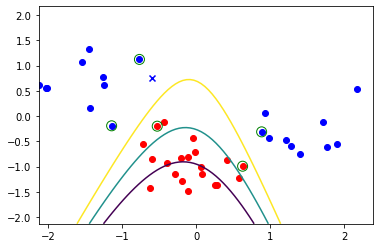

In [37]:
def test_polynomial_kernel(X, Y):
    kernel = polynomial_kernel
    kwargs = {'p': 2}
    lambdas = fit(X,
                  Y,
                  C=5,  # slack variable
                  kernel=kernel,
                  **kwargs)
    # Get the alpha values for the support vectors, as well as their target data.
    s_vecs, s_vecs_Y, s_vecs_alpha, b = get_support_vectors(X,
                                                         Y,
                                                         lambdas)

    ip_new = np.array([-0.6, 0.75])
    prediciton = predict(ip_new,
                         s_vecs,
                         s_vecs_Y,
                         s_vecs_alpha,
                         b,
                         kernel,
                         **kwargs)
    print(f"New point prediction: {prediciton}")
    plot_decision_boundary(Positive, Negative,
                           ip_new,
                           s_vecs,
                           s_vecs_Y,
                           s_vecs_alpha,
                           b,
                           kernel,
                           **kwargs)
if __name__ == '__main__':
    Positive, Negative = gen_data()
    X = np.concatenate((Positive, Negative))
    Y = np.concatenate((np.ones(Positive.shape[0]), -np.ones(Negative.shape[0])))
    size = X.shape[0]
    shuffle_data = list(range(size))
    random.shuffle(shuffle_data)
    X = X[shuffle_data, :]
    Y = Y[shuffle_data]

    # test_linear(X, Y)
    test_polynomial_kernel(X, Y)

Expected output.

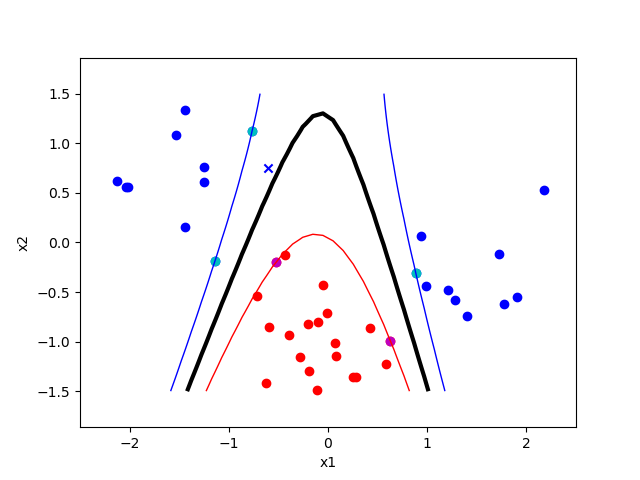

# Q2. Neural Networks (25 Points)

1. Forward Propagation : Find the value of L (7 points)
2. Backward Propagation: Find all the derivatives(of all xi,x2,y1,y2,z2,z2,z) wrt to each inputs and weights (18 points)

Consider the weights as shown below

![ANN.jpg](attachment:ANN.jpg)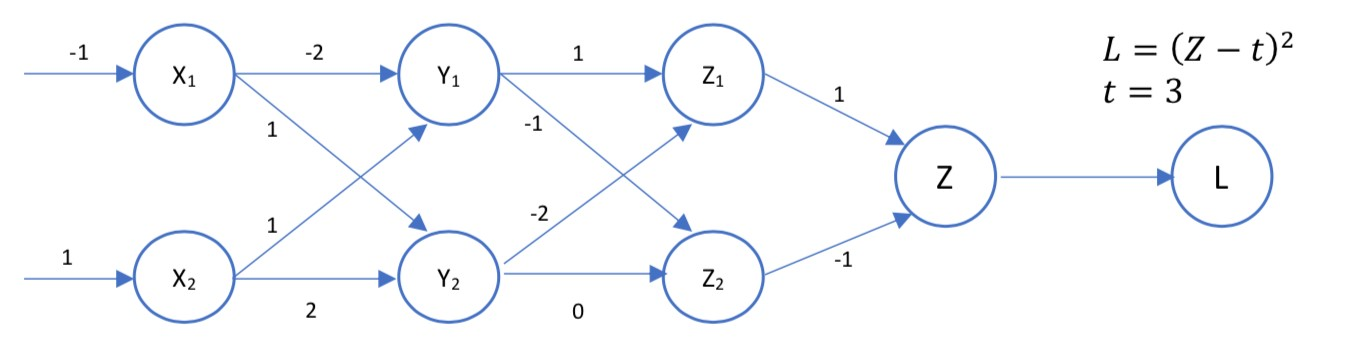

**Z has been renamed to o to prevent confusion with the previous layer's Z1 and Z2**

**Weights have been collected into matrices depending on the variable for that layer.  So, in order: WY, WZ, WO (with O referring to previously mentioned Z node**

$ x = \begin{bmatrix}-1 & 1\end{bmatrix}^T$
****
$Y1 = (X1)(W1_11) + (X2)(W1_21) = (-1)(-2) + (1)(1) = 3$

$Y2 = (X1)(W1_21) + (X2)(W1_22) = (-1)(1) + (1)(2) = 1$

-OR-

$y = WYx = \begin{bmatrix} 3 & 1\end{bmatrix}$
*****

$Z1 = (Y1)(W2_11) + (Y2)(W2_21) = (3)(1) + (1)(-2) = 1$

$Z2 = (Y1)(W2_12) + (Y2)(W2_22) = (3)(-1) + (1)(0) = -3$

-OR-

$z = WOz = \begin{bmatrix} 1 & -3\end{bmatrix}$
*****
(o refers the single Z node that leads to L - renamed to avoid confusion with z vars in previous layer)


$o = (Z1)(1) + (Z2)(-1) = (1)(1) + (-3)(-1) = 4$

-OR-

$o = WO z$
****
$L = (Z - t)^2 = (4 - 3)^2 = 1$

***
These are the weights that x is multiplied with to form Y

$ WY = \begin{bmatrix}-2 & 1 \\ 1 & 2\end{bmatrix}$

These are the weights that y is multiplied with to form z

$ WZ = \begin{bmatrix} 1 & -2 \\ -1 & 0\end{bmatrix}$

These are the weights that z is multiplied with to form z_out

$ WO = \begin{bmatrix} 1 & -1\end{bmatrix}^T$

In [38]:
# Feed forward
t = 3
WZ = np.matrix([[1,-2],[-1,0]]) # weights leading into the z layer (Z1, Z2)
WY = np.matrix([[-2, 1], [1, 2]]) # weights leading into the y layer
WO = np.matrix([1,-1]) # weights leading into the output layer (single Z layer)
x = np.matrix([-1,1]).T
y = WY.dot(x)
z = WZ.dot(y)
o = WO.dot(z) # o refers to the Z node by itself to avoid confusion with the previous Z vars
C = np.square((o - t))
print(f"Feed forward result: {C}")


Feed forward result: [[1]]


$\frac{\delta L}{\delta o} = 2(o - t) = 2$

$\frac{\delta o}{\delta Z1} = 1$

$\frac{\delta o}{\delta Z2} = -1$


$\frac{\delta Z1}{\delta Y1} = 1$

$\frac{\delta Z1}{\delta Y2} = -2$

$\frac{\delta Z2}{\delta Y1} = -1$

$\frac{\delta Z2}{\delta Y2} = 0$

$\frac{\delta Y1}{\delta X1} = -2$

$\frac{\delta Y1}{\delta X2} = 1$

$\frac{\delta Y2}{\delta X1} = 1$

$\frac{\delta Y2}{\delta X2} = 2$

$\frac{\delta L}{\delta Z1} = \frac{\delta L}{\delta o} \frac{\delta o}{\delta Z1} = (2)(1) = 2$


$\frac{\delta L}{\delta Z2} = \frac{\delta L}{\delta o} \frac{\delta o}{\delta Z2} = (2)(-1) = -2$


$\frac{\delta L}{\delta Y1} = \frac{\delta L}{\delta Z1} \frac{\delta Z1}{\delta Y1} +   \frac{\delta L}{\delta Z2} \frac{\delta Z2}{\delta Y1} = (2)(1) + (-2)(-1) = 4$

$\frac{\delta L}{\delta Y2} = \frac{\delta L}{\delta Z1} \frac{\delta Z1}{\delta Y2} +   \frac{\delta L}{\delta Z2} \frac{\delta Z2}{\delta Y2} = (2)(-2) + (-2)(0) = -4 $

$\frac{\delta L}{\delta X1} = \frac{\delta L}{\delta Y1} \frac{\delta Y1}{\delta X1} +   \frac{\delta L}{\delta Y2} \frac{\delta Y2}{\delta X1} = (4)(-2) + (-4)(1) = -12$

$\frac{\delta L}{\delta X2} = \frac{\delta L}{\delta Y1} \frac{\delta Y1}{\delta X2} +   \frac{\delta L}{\delta Y2} \frac{\delta Y2}{\delta X2} = (4)(1) + (-4)(2) = -4$


# Q3.Understanding Random Forest Classifier (40 Points)

1. Build a Random Forest classifier for the [handwritten digits dataset](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html#sklearn.datasets.load_digits/) and find its performance (classification report, confusion matrix) (3 Points)

In [39]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, plot_confusion_matrix
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

digits = load_digits()

# split data into training and testing sets
X = digits['data']
y = digits['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 1)

# instantiate classifier and fit
rfc = RandomForestClassifier(random_state=0)
rfc.fit(X_train, y_train)

# predict on test data
y_pred = rfc.predict(X_test)

# print reports
print(confusion_matrix(y_test, y_pred))
print(accuracy_score(y_test, y_pred))
target_names = ['0','1','2','3','4','5','6','7','8','9']
print(classification_report(y_test, y_pred, target_names=target_names))

[[42  0  0  0  1  0  0  0  0  0]
 [ 0 35  0  0  0  0  0  0  0  0]
 [ 0  0 36  0  0  0  0  0  0  0]
 [ 0  0  0 40  0  0  0  0  0  1]
 [ 0  0  0  0 38  0  0  0  0  0]
 [ 0  0  0  0  0 30  0  0  0  0]
 [ 0  0  0  0  0  0 37  0  0  0]
 [ 0  0  0  0  0  0  0 36  0  1]
 [ 0  0  0  0  0  1  0  0 27  1]
 [ 0  0  0  0  0  1  0  0  0 33]]
0.9833333333333333
              precision    recall  f1-score   support

           0       1.00      0.98      0.99        43
           1       1.00      1.00      1.00        35
           2       1.00      1.00      1.00        36
           3       1.00      0.98      0.99        41
           4       0.97      1.00      0.99        38
           5       0.94      1.00      0.97        30
           6       1.00      1.00      1.00        37
           7       1.00      0.97      0.99        37
           8       1.00      0.93      0.96        29
           9       0.92      0.97      0.94        34

    accuracy                           0.98       360


2. Investigate following parameters of Random Forest classifier and tune them using Randomized Search and Grid Search. (15 points)
- Number of nodes per tree
- Number of trees
- Depth of trees
- Minimum Samples to split
- Minumum Samples in leaf

Use seed 1 and split the data into 80/20 train/val sets. Traing a classifier with each unique configuration and record train/val accuracy, precision and recall in the results dataframe. This dataframe will have 5 columns (each corresponding to tuning parameter) and each row will correspond to each unique configuration. 5x5x5x5x5 rows. 

Visualize the results dataframe using [parallel coordinates](https://pandas.pydata.org/docs/reference/api/pandas.plotting.parallel_coordinates.html). You will create a column in results dataframe that contains label of each row. Create labels according to accuracy score 50-60 (D), 60-70 (C), 70-80 (B), 80-90 (A), 90+ (A+). These labels will be required for parallel coordinates plot.

Analyze of the impace of each tuning parameter on predictor performance.


In [40]:
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV
import pandas as pd
from pandas.plotting import parallel_coordinates

def grade_accuracy(accuracy):
  if acc >= 90:
    grade = 'A+'
  elif acc >= 80:
    grade = 'A'
  elif acc >= 70:
    grade = 'B'
  elif acc >= 60:
    grade = 'C'
  elif acc >= 50:
    grade = 'D'
  else:
    grade = 'F'
    
  return grade
 
# The paramater values are only suggestive. You can come up with better choices.

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 250, num = 5)]
# Number of features to consider at every split
max_features = [1,2,3]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 250, 5)]
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 8, 11, 14]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4, 6, 8]

# Run GridSearch to tune the hyper-parameter
from sklearn.model_selection import GridSearchCV
rfc=RandomForestClassifier()

k_fold_cv = 2

grid_params = {
 'n_estimators' : n_estimators,
 'max_features' : max_features,
 'max_depth': max_depth,
 'min_samples_split': min_samples_split,
 'min_samples_leaf': min_samples_leaf
 }

grid = GridSearchCV(rfc,
                    param_grid=grid_params,
                    cv=k_fold_cv, 
                    n_jobs = 4,
                    verbose = 0,
                    return_train_score=True)

grid.fit(X_train, y_train)

# just reusing the grid_params from the previous search
random_search = RandomizedSearchCV(RandomForestClassifier(),
                                   grid_params,
                                   n_iter = 1000,
                                   cv = 10)

random_search.fit(X_train, y_train)

grid_results = grid.cv_results_["params"]
random_results = random_search.cv_results_["params"]

grid_grades = []
random_grades = []

# stitch together the manufactured label column
# and the search results.
for idx, val in enumerate(grid_results):
  acc = grid.cv_results_['mean_test_score'][idx] * 100
  param = grid.cv_results_['params'][idx]
  grid_grades.append(grade_accuracy(acc))

# create pandas dataframe
df = pd.DataFrame.from_dict(grid_results)
df['label'] = grid_grades

# stitch together the manufactured label column
# and the search results.
for idx, val in enumerate(random_results):
  acc = grid.cv_results_['mean_test_score'][idx] * 100
  param = grid.cv_results_['params'][idx]
  random_grades.append(grade_accuracy(acc))

# create pandas dataframe
random_df = pd.DataFrame.from_dict(random_results)
random_df['label'] = random_grades



GridSearchCV results:


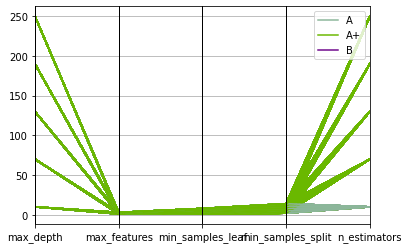

In [41]:
print(f"GridSearchCV results:")
parallel_coordinates(df, 'label')

RandomizedSearchCV results:


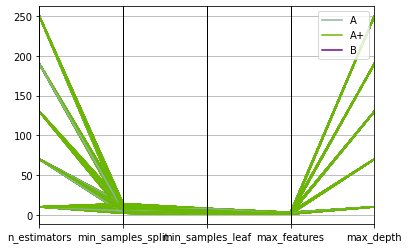

In [42]:
print(f"RandomizedSearchCV results:")
parallel_coordinates(random_df, 'label')

3. From the results of the above find the best estimators and use them for classifcation once again and evaluate the performance using 10 fold cross validation. (10 Points)

In [43]:
target_names = ['0','1','2','3','4','5','6','7','8','9']
# use best randomized search model on test data
#y_pred = random_search.predict(X_test)
y_pred_random = random_search.best_estimator_.predict(X_test)

# print reports
print(confusion_matrix(y_test, y_pred_random))
print(accuracy_score(y_test, y_pred_random))
print(classification_report(y_test, y_pred_random, target_names=target_names))

[[41  0  0  0  2  0  0  0  0  0]
 [ 0 35  0  0  0  0  0  0  0  0]
 [ 0  0 35  0  0  0  0  1  0  0]
 [ 0  0  0 41  0  0  0  0  0  0]
 [ 0  0  0  0 38  0  0  0  0  0]
 [ 0  0  0  0  0 30  0  0  0  0]
 [ 0  0  0  0  0  0 37  0  0  0]
 [ 0  0  0  0  0  0  0 36  0  1]
 [ 0  0  0  0  0  0  0  0 29  0]
 [ 0  0  0  0  0  1  0  0  0 33]]
0.9861111111111112
              precision    recall  f1-score   support

           0       1.00      0.95      0.98        43
           1       1.00      1.00      1.00        35
           2       1.00      0.97      0.99        36
           3       1.00      1.00      1.00        41
           4       0.95      1.00      0.97        38
           5       0.97      1.00      0.98        30
           6       1.00      1.00      1.00        37
           7       0.97      0.97      0.97        37
           8       1.00      1.00      1.00        29
           9       0.97      0.97      0.97        34

    accuracy                           0.99       360


In [44]:
# use best gridsearch model on test data
#y_pred = grid.predict(X_test)
y_pred_grid = grid.best_estimator_.predict(X_test)

# print reports
print(confusion_matrix(y_test, y_pred_grid))
print(accuracy_score(y_test, y_pred_grid))
print(classification_report(y_test, y_pred_grid, target_names=target_names))

[[41  0  0  0  2  0  0  0  0  0]
 [ 0 35  0  0  0  0  0  0  0  0]
 [ 0  0 35  0  0  0  0  1  0  0]
 [ 0  0  0 41  0  0  0  0  0  0]
 [ 0  0  0  0 38  0  0  0  0  0]
 [ 0  1  0  0  0 29  0  0  0  0]
 [ 0  0  0  0  0  0 37  0  0  0]
 [ 0  0  0  0  0  0  0 36  0  1]
 [ 0  0  0  0  0  0  0  0 29  0]
 [ 0  0  0  1  0  0  0  1  0 32]]
0.9805555555555555
              precision    recall  f1-score   support

           0       1.00      0.95      0.98        43
           1       0.97      1.00      0.99        35
           2       1.00      0.97      0.99        36
           3       0.98      1.00      0.99        41
           4       0.95      1.00      0.97        38
           5       1.00      0.97      0.98        30
           6       1.00      1.00      1.00        37
           7       0.95      0.97      0.96        37
           8       1.00      1.00      1.00        29
           9       0.97      0.94      0.96        34

    accuracy                           0.98       360


In [45]:
# evaluate a logistic regression model using k-fold cross-validation
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
# prepare the cross-validation procedure
cv = KFold(n_splits=10, random_state=1, shuffle=True)
# create model
random_model = random_search.best_estimator_ #RandomForestClassifier()
grid_model = grid.best_estimator_
# evaluate model
random_scores = cross_val_score(random_model, X_test, y_test, scoring='accuracy', cv=cv, n_jobs=-1)
grid_scores = cross_val_score(grid_model, X_test, y_test, scoring='accuracy', cv=cv, n_jobs=-1)
# report performance
print('Randomized Accuracy: %.3f (%.3f)' % (mean(random_scores), std(random_scores)))
print('Grid Accuracy: %.3f (%.3f)' % (mean(grid_scores), std(grid_scores)))

Randomized Accuracy: 0.958 (0.022)
Grid Accuracy: 0.950 (0.024)


4. Describe what is the difference between Randomized Search and Grid Search (4 points)

Where grid search will systematically search the parameter space, random search will select parameters at random and will not necessarily test all values.

The obvious tradeoff here is that grid search is more exhaustive, but is likely to become too time-consuming with very many parameter choices.  A randomized search will likely be preferable in instances where the parameter space is simply too large for an exhaustive search.


5. Why do we have to perfrom cross validation (3 points)


Cross validation allows us to use all of our data when training.  It allows us to try more parameters and different models with the data we have.  It gives us confidence that our model will perform better on unseen data.


6. Explain how each of the parameters of Random Forest considered effect the performance (5 points)

max_depth: This will control the maximum depth of the potential model. A shallower tree will have a lower bias, but since different input data will result in very different outcomes, it will have a high variance. A deeper tree will be very prone to overfitting.

max_features: This controls the number of features a given tree will have available for learning.  There's a definite benefit to more features early on, but the benefit quickly recedes. 

min_features: A higher number here will result in fewer nodes.A smaller number will result in more splits, and overfitting.

min_samples: Reducing the min_samples will reduce the number of splits in the forest, and have the ultimate effect of reducing overfitting.

n_estimators:  How many trees will be used in total?  Obviously more gets a better result at computational cost.


In [46]:
print(f"Random search best params: {random_search.best_params_}")
print(f"Grid search best params: {grid.best_params_}")


Random search best params: {'n_estimators': 250, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 3, 'max_depth': 190}
Grid search best params: {'max_depth': 250, 'max_features': 2, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 190}
